In [2]:
from empath import Empath
lexicon = Empath()
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import ssl
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
import string
from tqdm import tqdm
import collections
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from textblob import Word

import plotly.offline as pyoff
import plotly.graph_objs as go
from spellchecker import SpellChecker

import torch
import torch.nn as nn

spell = SpellChecker()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_true_news = pd.read_csv("/Users/luxinyuan/Downloads/archive-4/True.csv")  
df_fake_news = pd.read_csv("/Users/luxinyuan/Downloads/archive-4/Fake.csv")

missing_rows_true = df_true_news.isnull().sum()
missing_rows_true

missing_rows_fake = df_fake_news.isnull().sum()
missing_rows_fake

duplicate_rows = df_true_news.duplicated().sum()  #206 duplicates term
df_true_news.drop_duplicates(inplace = True)
df_true_news['output'] = 1

duplicate_rows = df_fake_news.duplicated().sum()  #206 duplicates term
df_fake_news.drop_duplicates(inplace = True)
df_fake_news['output'] = 0

data_total = df_fake_news.append(df_true_news)
data_total = data_total.reset_index(drop=True)

patternDel = "http"
filter1 = data_total['date'].str.contains(patternDel)
data_total = data_total[~filter1]                 #remove 9 term
pattern = "Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec"
filter2 = data_total['date'].str.contains(pattern)
data_total = data_total[filter2]                  #remove 1 term
data_total['date'] = pd.to_datetime(data_total['date'])
data_total = data_total.reset_index(drop=True)
data_total = data_total[data_total['text'] != ' '] #remove 627 terms
data_total = data_total.reset_index(drop=True)

Subject vs Output 

In [4]:
data_sub=data_total.groupby(['subject', 'output'])['text'].count()
data_sub = data_sub.unstack().fillna(0)
data_sub

output,0,1
subject,,
Government News,1497.0,0.0
Middle-east,778.0,0.0
News,9050.0,0.0
US_News,783.0,0.0
left-news,4307.0,0.0
politics,6427.0,0.0
politicsNews,0.0,11219.0
worldnews,0.0,9991.0


Proportion of Output

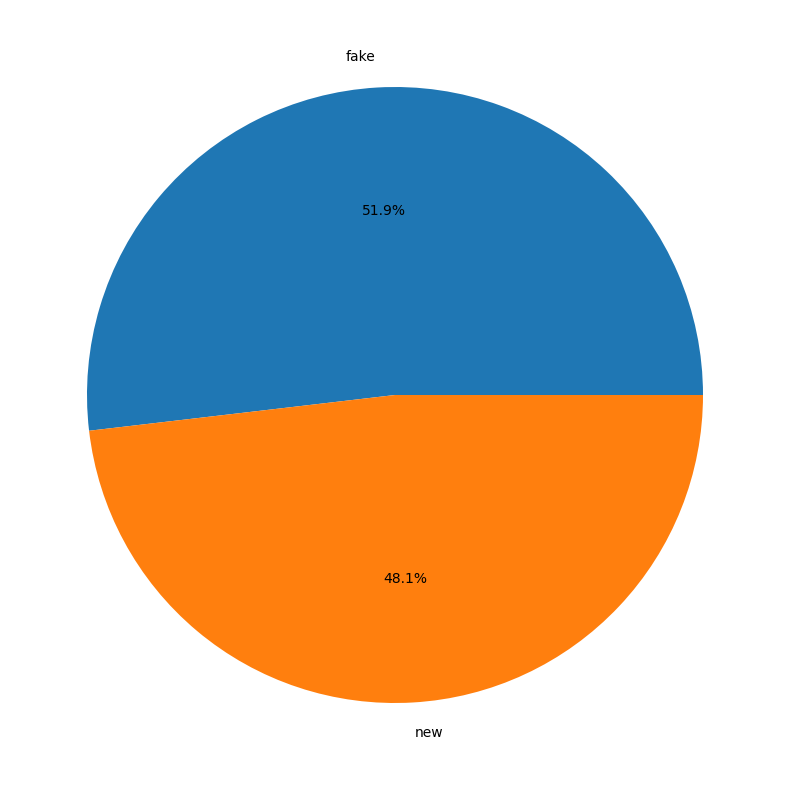

In [5]:
counts = data_total["output"].value_counts()
class_labels = ["fake",'new']
counts_per_class = [counts[0], counts[1]]

# counts.plot(kind='barh')

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.show()

Date_difference vs Output

In [6]:
df_date = data_total.copy(deep = True)
df_date=data_total.sort_values(by=['date'])
df_date=df_date.reset_index(drop=True)
df_date1=df_date[df_date['output']==1]
df_date1=df_date1.groupby(['date'])['output'].count()
df_date1=pd.DataFrame(df_date1)
df_date0=df_date[df_date['output']==0]
df_date0=df_date0.groupby(['date'])['output'].count()
df_date0=pd.DataFrame(df_date0) 
plot_data = [
    go.Scatter(
        x=df_date1.index,
        y=df_date1['output'],
        name='True',
        #x_axis="OTI",
        #y_axis="time",
    ),
    go.Scatter(
        x=df_date0.index,
        y=df_date0['output'],
        name='Fake'
    )
    
]
plot_layout = go.Layout(
        title='Day-wise',
        yaxis_title='Count',
        xaxis_title='Time',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Adding mistake

In [37]:
data_mistake = data_total.copy(deep = True)

data_mistake['mistake'] = 0

new_text = []
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()

for txt in data_mistake.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)
data_mistake['text'] = new_text


def check_word_spelling(word):
    
    word = Word(word)
    
    result = word.spellcheck()
    
    if word != result[0][0]:
        return 1
    else:
        return 0
    
def check_sentence_spelling(index):

    words = data_mistake['text'][index].split()

    n = 0
    for word in words:
        n = n + check_word_spelling(word)
    return [index,n]

    
result = []
def fun_collect(x):
    result.append(x)    



import multiprocessing
def _apply_async():
    # 必须close+join，否则主进程跑完了，子进程还没完，就会报错
    pool = multiprocessing.Pool()

    for i in range(data_mistake.shape[0]):
        # proc_lst.append(pool.apply_async(square, args=(i,)))
        pool.apply_async(check_sentence_spelling, args=(i,),callback = fun_collect)
    pool.close()
    pool.join()

_apply_async()

KeyboardInterrupt: 

In [ ]:
result1 = pd.DataFrame(result)

result1 = result1.sort_values(by=0,ascending=True)

result1 = result1.reset_index(drop = True)


data_mistake['mistake'] = result1[1] 

(0.0, 100.0)

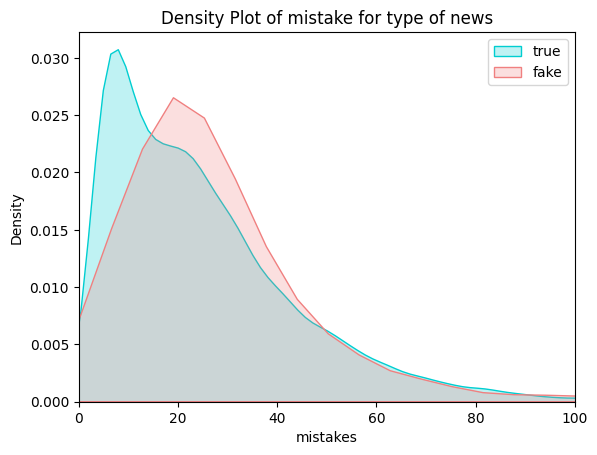

In [33]:
ax = sns.kdeplot(data_mistake['mistake'][data_mistake.output==1],color='darkturquoise',fill=True)
sns.kdeplot(data_mistake['mistake'][data_mistake.output==0],color='lightcoral',fill=True)
plt.legend(['true','fake'])
plt.title('Density Plot of mistake for type of news')
ax.set(xlabel='mistakes')
plt.xlim(0,100) #x轴取值范围

In [9]:
data_mistake['mistake'] = (data_mistake['mistake']-min(data_mistake['mistake']))/(max(data_mistake['mistake'])-min(data_mistake['mistake']))
data_total['mistake'] = data_mistake['mistake']

In [ ]:
ax = sns.kdeplot(data_total['mistake'][data_total.output==1],color='darkturquoise',fill=True)
sns.kdeplot(data_total['mistake'][data_total.output==0],color='lightcoral',fill=True)
plt.legend(['fake','true'])
plt.title('Density Plot of mistake for type of news')
ax.set(xlabel='mistake')
plt.xlim(0,0.06) #x轴取值范围

Getting CL

In [11]:
data_total2 = data_total.copy(deep = True)
data_total2['word_count'] = data_total2["text"].apply(lambda x: len(str(x).split(" ")))
data_total2['char_count'] =data_total2["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
x = data_total2.loc[:,'word_count':'char_count']
xmin   = x.min(axis=0)
xmax   = x.max(axis=0)
x_norm = (x-xmin)/(xmax-xmin)
data_total2['word_count'] = x_norm['word_count']
data_total2['char_count'] = x_norm['char_count']
data_total = data_total2.copy(deep=True)

Getting NER

In [66]:
data_total3 = data_total.copy(deep = True)

In [67]:
ner = spacy.load("en_core_web_sm")

## tag text and exctract tags into a list
data_total3["tags"] = data_total3["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] )

## utils function to count the element of a list

def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

data_total3["tags"] = data_total3["tags"].apply(lambda x: utils_lst_count(x))

## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

In [68]:
tags_set = []
for lst in data_total3["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     data_total3["tags_"+feature] = data_total3["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))
## extract features

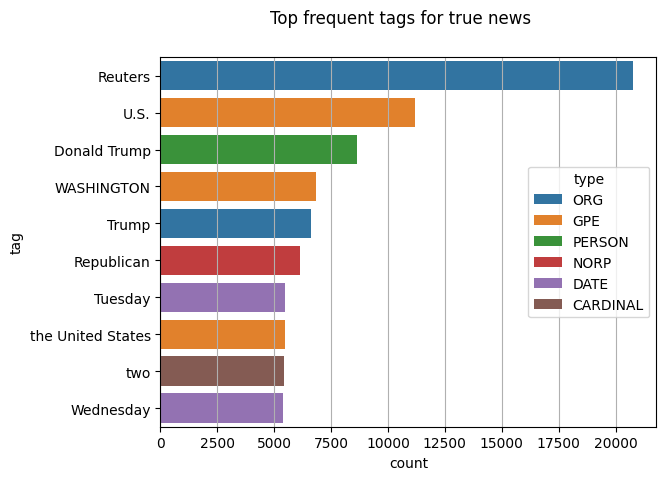

In [123]:
y = 1
 
tags_list = data_total3[data_total3["output"]==y]["tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags for true news", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
            data=dtf_tags.iloc[:10,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

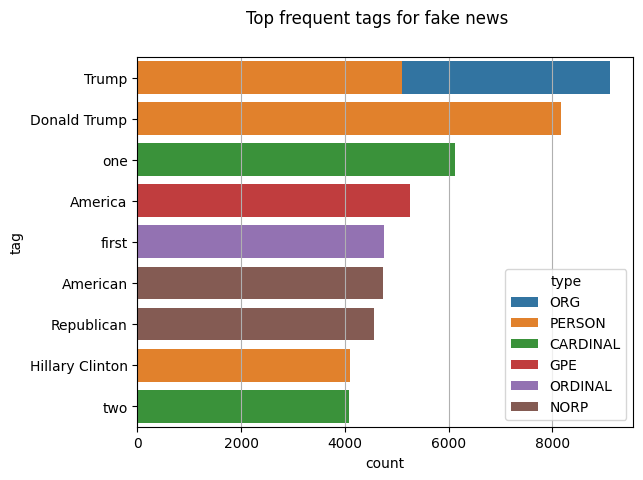

In [124]:
y = 0
 
tags_list = data_total3[data_total3["output"]==y]["tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags for fake news", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
            data=dtf_tags.iloc[:10,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

In [79]:
## NER 的数据归一化
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit_transform(data_total3.iloc[:,9:27])
data_total3.iloc[:,9:27] = min_max_scaler.fit_transform(data_total3.iloc[:,9:27])


In [80]:
df_ = data_total3.copy(deep = True)
data_total  = data_total3.copy(deep = True)

N_gram  
5.1 with Stop Word

In [14]:
stop_words = set(stopwords.words('english'))
def process(s):
    s = word_tokenize(s)
    s = [w for w in s if not w in stop_words] #optional
    return s

In [15]:
# 5.1.1
df_ = df_.copy(deep = True)
df_['news']=df_['title']
df_['news'] = df_.apply(lambda x: x['news'].lower(),axis=1)
df_["news"] = df_['news'].str.replace('[^\w\s]','')
for i in tqdm(range(df_.shape[0])):
    df_['news'].iloc[i] = process(df_['news'].iloc[i])
for i in tqdm(range(df_.shape[0])):
    df_['news'].iloc[i] = " ".join(df_['news'].iloc[i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

  0%|          | 0/44052 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 44052/44052 [00:09<00:00, 4473.27it/s]


In [16]:
def basic_clean(text):
    
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  df_['news'] = df_.apply(lambda x: x['news'].lower(),axis=1)
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [21]:
## 1 gram for true news
real_news=pd.DataFrame(pd.Series(' '.join(df_[df_['output']==1]['news']).split()).value_counts())

real_news30=real_news.head(5)
plot_data = [
    go.Bar(
        x=real_news30.index,
        y=real_news30[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = real_news30[0]
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 words from True news',
        yaxis_title='Count',
        xaxis_title='word',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [20]:
## 1 gram for fake

fake_news=pd.DataFrame(pd.Series(' '.join(df_[df_['output']==0]['news']).split()).value_counts())

fake_news30=fake_news.head(5)

plot_data = [
    go.Bar(
        x=fake_news30.index,
        y=fake_news30[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = fake_news30[0]
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 words from Fake news',
        yaxis_title='Count',
        xaxis_title='Word',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [22]:
## 2 gram for fake news

fake_words = basic_clean(''.join(str(df_[df_['output']==0]['news'].tolist())))

bigram_fake=(pd.Series(nltk.ngrams(fake_words, 2)).value_counts())[:5]
bigram_fake=pd.DataFrame(bigram_fake)
bigram_fake['in']=bigram_fake.index
bigram_fake['in'] = bigram_fake.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+')',axis=1)
plot_data = [
    go.Bar(
        x=bigram_fake['in'],
        y=bigram_fake[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 bi-grams from Fake News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [23]:
## 2 gram for true news

true_words = basic_clean(''.join(str(df_[df_['output']==1]['news'].tolist())))
bigram_true=(pd.Series(nltk.ngrams(true_words, 2)).value_counts())[:5]
bigram_true=pd.DataFrame(bigram_true)
bigram_true['in']=bigram_true.index
bigram_true['in'] = bigram_true.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+')',axis=1)
plot_data = [
    go.Bar(
        x=bigram_true['in'],
        y=bigram_true[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 bi-grams from True News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [77]:
data_total

,title,text,subject,date,output,mistake,word_count,char_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,0.032020,0.061055,0.054844
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,0.025452,0.036515,0.036671
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,0.029557,0.071014,0.069144
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,0.022167,0.056194,0.053046
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,0.036946,0.051334,0.044120
...,...,...,...,...,...,...,...,...
44047,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1,0.038588,0.057380,0.053899
44048,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1,0.018883,0.015768,0.015383
44049,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1,0.201149,0.039834,0.037224
44050,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1,0.026273,0.025133,0.022763


In [118]:
#5.1.2
df_ = data_total.copy(deep = True)
df_['news']=df_['text']
df_['news'] = df_.apply(lambda x: x['news'].lower(),axis=1)
df_["news"] = df_['news'].str.replace('[^\w\s]','')
df_["news"] = df_['news'].str.replace('reuters',' ')
for i in tqdm(range(df_.shape[0])):
    df_['news'].iloc[i] = process(df_['news'].iloc[i])
for i in tqdm(range(df_.shape[0])):
    df_['news'].iloc[i] = " ".join(df_['news'].iloc[i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

  0%|          | 0/44052 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 44052/44052 [00:20<00:00, 2191.79it/s]


In [37]:
## 1 gram for true news
real_news=pd.DataFrame(pd.Series(' '.join(df_[df_['output']==1]['news']).split()).value_counts())

real_news30=real_news.head(10)
plot_data = [
    go.Bar(
        x=real_news30.index,
        y=real_news30[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = real_news30[0]
        )
    )
]
plot_layout = go.Layout(
        title='Top 10 words from true news',
        yaxis_title='Count',
        xaxis_title='Word',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [38]:
## 1 gram for fake

fake_news=pd.DataFrame(pd.Series(' '.join(df_[df_['output']==0]['news']).split()).value_counts())

fake_news30=fake_news.head(10)

plot_data = [
    go.Bar(
        x=fake_news30.index,
        y=fake_news30[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = fake_news30[0]
        )
    )
]
plot_layout = go.Layout(
        title='Top 10 words from Fake news',
        yaxis_title='Count',
        xaxis_title='Word',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [87]:
## 2 gram for fake news

fake_words = basic_clean(''.join(str(df_[df_['output']==0]['news'].tolist())))

bigram_fake=(pd.Series(nltk.ngrams(fake_words, 2)).value_counts())[:5]
bigram_fake=pd.DataFrame(bigram_fake)
bigram_fake['in']=bigram_fake.index
bigram_fake['in'] = bigram_fake.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+')',axis=1)
plot_data = [
    go.Bar(
        x=bigram_fake['in'],
        y=bigram_fake[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 5 bi-grams from Fake News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [86]:
## 2 gram for true news

true_words = basic_clean(''.join(str(df_[df_['output']==1]['news'].tolist())))
bigram_true=(pd.Series(nltk.ngrams(true_words, 2)).value_counts())[:5]
bigram_true=pd.DataFrame(bigram_true)
bigram_true['in']=bigram_true.index
bigram_true['in'] = bigram_true.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+')',axis=1)
plot_data = [
    go.Bar(
        x=bigram_true['in'],
        y=bigram_true[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 5 bi-grams from True News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [64]:
## 3 gram for fake news
trigram_fake=(pd.Series(nltk.ngrams(fake_words, 3)).value_counts())[:5]
trigram_fake=pd.DataFrame(trigram_fake)
trigram_fake['in']=trigram_fake.index
trigram_fake['in'] = trigram_fake.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+', '+x['in'][2]+')',axis=1)
plot_data = [
    go.Bar(
        x=trigram_fake['in'],
        y=trigram_fake[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 5 tri-grams from Fake News',
        yaxis_title='Count',
        xaxis_title='tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [65]:
## 3 gram for true news
trigram_true=(pd.Series(nltk.ngrams(true_words, 3)).value_counts())[:5]
trigram_true=pd.DataFrame(trigram_true)
trigram_true['in']=trigram_true.index
trigram_true['in'] = trigram_true.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+', '+x['in'][2]+')',axis=1)
plot_data = [
    go.Bar(
        x=trigram_true['in'],
        y=trigram_true[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 5 tri-grams from True News',
        yaxis_title='Count',
        xaxis_title='tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [94]:
#5.1.3
df_ = df_.copy(deep = True)
df_['news']=df_['title'] +''+df_['text']
df_['news'] = df_.apply(lambda x: x['news'].lower(),axis=1)
df_["news"] = df_['news'].str.replace('[^\w\s]','')
for i in tqdm(range(df_.shape[0])):
    df_['news'].iloc[i] = process(df_['news'].iloc[i])
for i in tqdm(range(df_.shape[0])):
    df_['news'].iloc[i] = " ".join(df_['news'].iloc[i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

100%|██████████| 44052/44052 [00:14<00:00, 3097.98it/s]


In [95]:
## 1-gram for total

all_news=pd.DataFrame(pd.Series(' '.join(df_['news']).split()).value_counts())
allnews1=all_news.head(30)

plot_data = [
    go.Bar(
        x=allnews1.index,
        y=allnews1[0],
        name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = allnews1[0]
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 words',
        yaxis_title='Count',
        xaxis_title='Word',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [96]:
## 1 gram for fake

fake_news=pd.DataFrame(pd.Series(' '.join(df_[df_['output']==0]['news']).split()).value_counts())

fake_news30=fake_news.head(30)

plot_data = [
    go.Bar(
        x=fake_news30.index,
        y=fake_news30[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = fake_news30[0]
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 words from Fake news',
        yaxis_title='Count',
        xaxis_title='Word',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [97]:
## 1 gram for true news
real_news=pd.DataFrame(pd.Series(' '.join(df_[df_['output']==1]['news']).split()).value_counts())

real_news30=real_news.head(30)
plot_data = [
    go.Bar(
        x=real_news30.index,
        y=real_news30[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = real_news30[0]
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 words from Real news',
        yaxis_title='Count',
        xaxis_title='Word',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [98]:
## 2 gram for fake news

fake_words = basic_clean(''.join(str(df_[df_['output']==0]['news'].tolist())))

bigram_fake=(pd.Series(nltk.ngrams(fake_words, 2)).value_counts())[:30]
bigram_fake=pd.DataFrame(bigram_fake)
bigram_fake['in']=bigram_fake.index
bigram_fake['in'] = bigram_fake.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+')',axis=1)
plot_data = [
    go.Bar(
        x=bigram_fake['in'],
        y=bigram_fake[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 bi-grams from Fake News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [99]:
## 2 gram for true news

true_words = basic_clean(''.join(str(df_[df_['output']==1]['news'].tolist())))
bigram_true=(pd.Series(nltk.ngrams(true_words, 2)).value_counts())[:30]
bigram_true=pd.DataFrame(bigram_true)
bigram_true['in']=bigram_true.index
bigram_true['in'] = bigram_true.apply(lambda x: '('+x['in'][0]+', '+x['in'][1]+')',axis=1)
plot_data = [
    go.Bar(
        x=bigram_true['in'],
        y=bigram_true[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 bi-grams from True News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['output'], 
                                                    random_state=1)

In [120]:
vect = CountVectorizer(min_df = 200,ngram_range=(1,2)).fit(X_train)

In [121]:
X_train_vectorized = vect.transform(X_train)

In [122]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))


feature_names = np.array(vect.get_feature_names_out())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['via' 'president trump' 'rep' 'saidthe' 'mr' 'gop' 'sen' 'obama'
 'hillary' 'gov']

Largest Coefs: 
['trumps' 'washington us' 'us president' 'im' 'wednesday' 'thursday'
 'president donald' 'tuesday' 'friday' 'dont']


In [116]:
data_test = data_total.copy(deep = True)
pattern = "trump"
filter_test = data_total['text'].str.contains(pattern)
data_test['n1'] = filter_test+0 
pattern = "president donald"
filter_test = data_total['text'].str.contains(pattern)
data_test['n2'] = filter_test+0 
pattern = "hillary"
filter_test = data_total['text'].str.contains(pattern)
data_test['n3'] = filter_test+0 
pattern = "gap"
filter_test = data_total['text'].str.contains(pattern)
data_test['n4'] = filter_test+0 
pattern = "via video"
filter_test = data_total['text'].str.contains(pattern)
data_test['n5'] = filter_test+0            
 

In [117]:
sum(data_test['n2'])

0

      0     1
0  5631    91
1    63  5228
测试数据指标:
               precision    recall  f1-score   support

           0     0.9889    0.9841    0.9865      5722
           1     0.9829    0.9881    0.9855      5291

    accuracy                         0.9860     11013
   macro avg     0.9859    0.9861    0.9860     11013
weighted avg     0.9860    0.9860    0.9860     11013



Text(0.5, 23.52222222222222, 'Forecast type')

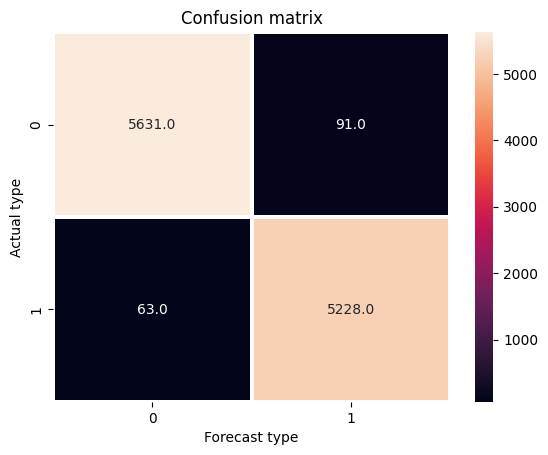

In [106]:
labelEncoder = LabelEncoder()
labelEncoder.fit(df_['output'])##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, predictions)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)
print('测试数据指标:\n',classification_report(y_test, predictions,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

ANN N

      0     1
0  4408  1314
1   911  4380
测试数据指标:
               precision    recall  f1-score   support

         0.0     0.8287    0.7704    0.7985      5722
         1.0     0.7692    0.8278    0.7975      5291

    accuracy                         0.7980     11013
   macro avg     0.7990    0.7991    0.7980     11013
weighted avg     0.8001    0.7980    0.7980     11013



Text(0.5, 23.52222222222222, 'Forecast type')

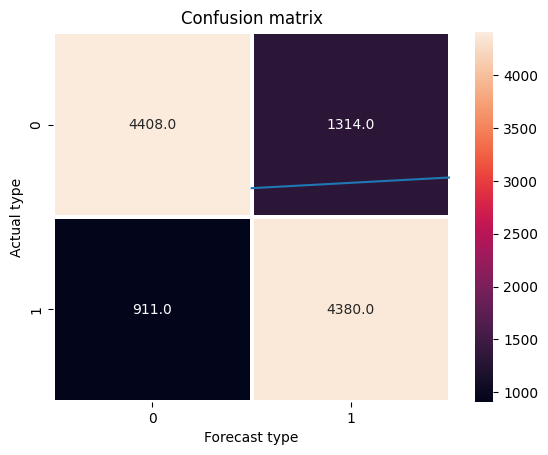

In [167]:
data_totaltry = df_.copy(deep = True)
new_text = data_totaltry['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
  
new_text = []
for txt in data_totaltry.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)

vectorizer_text = CountVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


# Creating Y
y = data_totaltry.output
# Creating X
x = text_matrix

X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.25,random_state=1)

class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN,self).__init__() # Inhertiting
        
        self.linear1 = nn.Linear(X_train.shape[1],20) #  OUT 2000
        self.relu1 = nn.ReLU() # Actfunc 1
        
        self.linear2 = nn.Linear(20,5) # IN 2000 OUT 500
        self.relu2 = nn.ReLU()
        
        self.linear5 = nn.Linear(5,2) # IN 20 OUT 2 | OUTPUT 
        
    
    def forward(self,x):
        
        out = self.linear1(x) # Input Layer 
        out = self.relu1(out)
        
        out = self.linear2(out) # Hidden Layer 1 
        out = self.relu2(out)

        
        out = self.linear5(out) # Output Layer
        
        return out
    

model = ANN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
error = nn.CrossEntropyLoss()

# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

EPOCHS = 100
train_losses = []
for epoch in range(EPOCHS):
    
    # Clearing gradients
    optimizer.zero_grad()
    
    # Forward Propagation
    outs = model(X_train)
    
    # Computing Loss
    train_loss = 0
    loss = error(outs,Y_train)
    train_loss += loss.item()
    # Backward propagation
    loss.backward()
    # Updating parameters
    optimizer.step()
    
    # Printing loss
    train_losses.append(train_loss)


rg = list(range(1,101))
plt.plot(rg,train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Prediction
y_head = model(X_test)
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(Y_test, y_pred)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)
print('测试数据指标:\n',classification_report(Y_test, y_pred,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

ANN N+M

In [156]:
data_totalM = df_.copy(deep = True)
data_totalM = data_totalM.drop("date",axis=1)

new_text = data_totalM['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()


new_text = []
for txt in data_totalM.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)


vectorizer_text = CountVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


# Creating Y
y = data_totalM.output
# Creating X
x = np.concatenate((np.array(data_totalM[['mistake']]),text_matrix),axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.25,random_state=1)

In [157]:
class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN,self).__init__() # Inhertiting
        
        self.linear1 = nn.Linear(X_train.shape[1],20) #  OUT 2000
        self.relu1 = nn.ReLU() # Actfunc 1
        
        self.linear2 = nn.Linear(20,5) # IN 2000 OUT 500
        self.relu2 = nn.ReLU()
        
        self.linear5 = nn.Linear(5,2) # IN 20 OUT 2 | OUTPUT 
        
    
    def forward(self,x):
        
        out = self.linear1(x) # Input Layer 
        out = self.relu1(out)
        
        out = self.linear2(out) # Hidden Layer 1 
        out = self.relu2(out)

        
        out = self.linear5(out) # Output Layer
        
        return out
    

model = ANN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
error = nn.CrossEntropyLoss()

In [158]:
# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

EPOCHS = 20
train_losses = []
for epoch in range(EPOCHS):
    
    # Clearing gradients
    optimizer.zero_grad()
    
    # Forward Propagation
    outs = model(X_train)
    
    # Computing Loss
    train_loss = 0
    loss = error(outs,Y_train)
    train_loss += loss.item()
    # Backward propagation
    loss.backward()
    # Updating parameters
    optimizer.step()
    
    # Printing loss
    train_losses.append(train_loss)
    print(f"Loss after iteration {epoch} is {loss}") 

Loss after iteration 0 is 0.6751236319541931
Loss after iteration 1 is 0.6347391605377197
Loss after iteration 2 is 0.6064819097518921
Loss after iteration 3 is 0.5858595371246338
Loss after iteration 4 is 0.5668632984161377
Loss after iteration 5 is 0.5497945547103882
Loss after iteration 6 is 0.5350948572158813
Loss after iteration 7 is 0.5218155980110168
Loss after iteration 8 is 0.50957852602005
Loss after iteration 9 is 0.49943265318870544
Loss after iteration 10 is 0.49200502038002014
Loss after iteration 11 is 0.48685142397880554
Loss after iteration 12 is 0.4836450517177582
Loss after iteration 13 is 0.4826650023460388
Loss after iteration 14 is 0.4831153154373169
Loss after iteration 15 is 0.48399871587753296
Loss after iteration 16 is 0.48507314920425415
Loss after iteration 17 is 0.4858313202857971
Loss after iteration 18 is 0.48577451705932617
Loss after iteration 19 is 0.484963059425354


Text(0, 0.5, 'Loss')

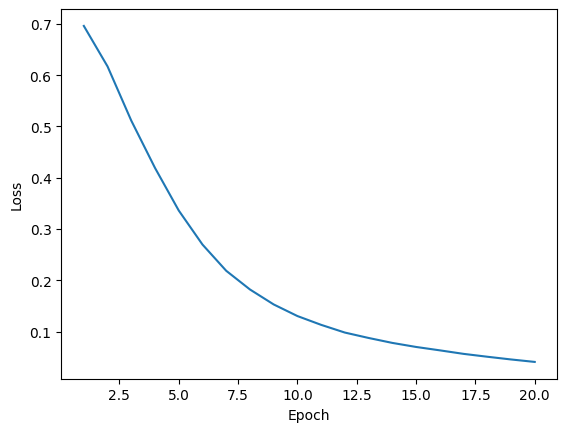

In [154]:
rg = list(range(1,101))
plt.plot(rg,train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

tensor([-1.5904, -4.5128], grad_fn=<SelectBackward0>)
tensor(0)
      0     1
0  4499  1223
1  1085  4206
测试数据指标:
               precision    recall  f1-score   support

         0.0     0.8057    0.7863    0.7959      5722
         1.0     0.7747    0.7949    0.7847      5291

    accuracy                         0.7904     11013
   macro avg     0.7902    0.7906    0.7903     11013
weighted avg     0.7908    0.7904    0.7905     11013



Text(0.5, 23.52222222222222, 'Forecast type')

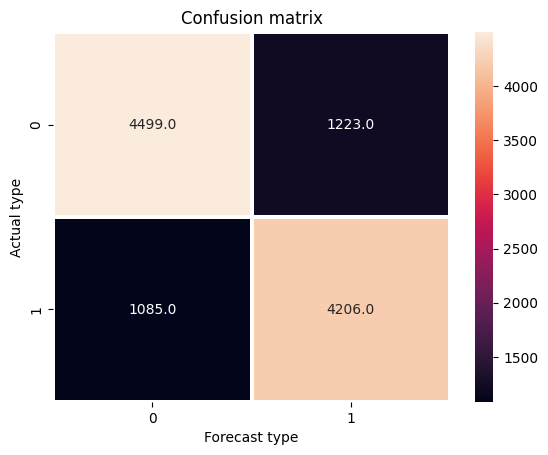

In [159]:
# Prediction
y_head = model(X_test)
print(y_head[0])
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]
print(y_pred[0])

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(Y_test, y_pred)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)
print('测试数据指标:\n',classification_report(Y_test, y_pred,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

ANN N + CL

      0     1
0  4441  1281
1   938  4353
测试数据指标:
               precision    recall  f1-score   support

         0.0     0.8256    0.7761    0.8001      5722
         1.0     0.7726    0.8227    0.7969      5291

    accuracy                         0.7985     11013
   macro avg     0.7991    0.7994    0.7985     11013
weighted avg     0.8002    0.7985    0.7986     11013



Text(0.5, 23.52222222222222, 'Forecast type')

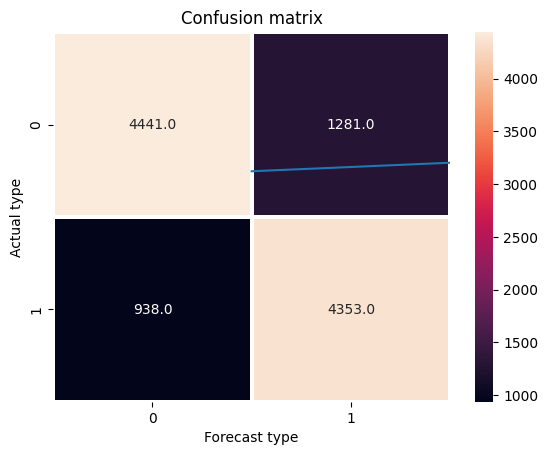

In [160]:
data_totaltry = df_.copy(deep = True)
new_text = data_totaltry['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
  
new_text = []
for txt in data_totaltry.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)

vectorizer_text = CountVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


# Creating Y
y = data_totaltry.output
# Creating X
x = np.concatenate((np.array(data_totaltry[['word_count','char_count']]),text_matrix),axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.25,random_state=1)

class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN,self).__init__() # Inhertiting
        
        self.linear1 = nn.Linear(X_train.shape[1],20) #  OUT 2000
        self.relu1 = nn.ReLU() # Actfunc 1
        
        self.linear2 = nn.Linear(20,5) # IN 2000 OUT 500
        self.relu2 = nn.ReLU()
        
        self.linear5 = nn.Linear(5,2) # IN 20 OUT 2 | OUTPUT 
        
    
    def forward(self,x):
        
        out = self.linear1(x) # Input Layer 
        out = self.relu1(out)
        
        out = self.linear2(out) # Hidden Layer 1 
        out = self.relu2(out)

        
        out = self.linear5(out) # Output Layer
        
        return out
    

model = ANN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
error = nn.CrossEntropyLoss()

# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

EPOCHS = 100
train_losses = []
for epoch in range(EPOCHS):
    
    # Clearing gradients
    optimizer.zero_grad()
    
    # Forward Propagation
    outs = model(X_train)
    
    # Computing Loss
    train_loss = 0
    loss = error(outs,Y_train)
    train_loss += loss.item()
    # Backward propagation
    loss.backward()
    # Updating parameters
    optimizer.step()
    
    # Printing loss
    train_losses.append(train_loss)


rg = list(range(1,101))
plt.plot(rg,train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Prediction
y_head = model(X_test)
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(Y_test, y_pred)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)
print('测试数据指标:\n',classification_report(Y_test, y_pred,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

(0.0, 0.2)

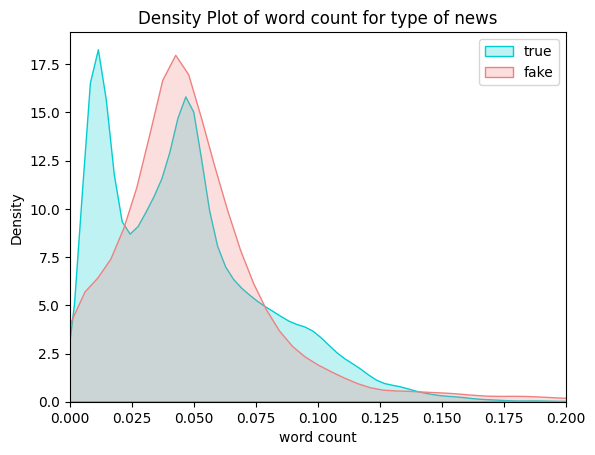

In [242]:
ax = sns.kdeplot(data_total2['word_count'][data_total2.output==1],color='darkturquoise',fill=True)
sns.kdeplot(data_total2['word_count'][data_total2.output==0],color='lightcoral',fill=True)
plt.legend(['true','fake'])
plt.title('Density Plot of word count for type of news')
ax.set(xlabel='word count')
plt.xlim(0,0.2) #x轴取值范围

(0.0, 0.2)

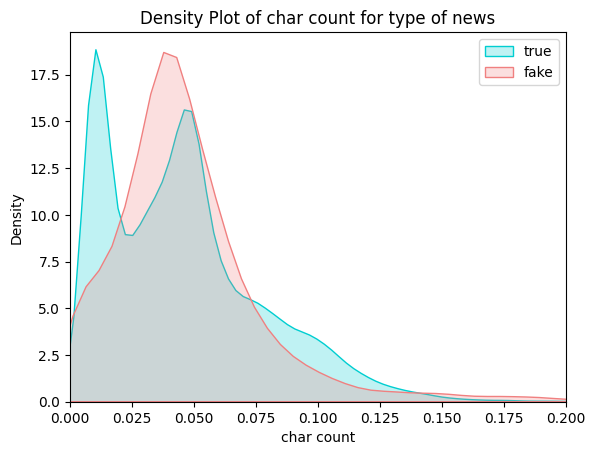

In [243]:
ax = sns.kdeplot(data_total2['char_count'][data_total2.output==1],color='darkturquoise',fill=True)
sns.kdeplot(data_total2['char_count'][data_total2.output==0],color='lightcoral',fill=True)
plt.legend(['true','fake'])
plt.title('Density Plot of char count for type of news')
ax.set(xlabel='char count')
plt.xlim(0,0.2) #x轴取值范围

ANN N + NE

      0     1
0  4520  1202
1   713  4578
测试数据指标:
               precision    recall  f1-score   support

         0.0     0.8637    0.7899    0.8252      5722
         1.0     0.7920    0.8652    0.8270      5291

    accuracy                         0.8261     11013
   macro avg     0.8279    0.8276    0.8261     11013
weighted avg     0.8293    0.8261    0.8261     11013



Text(0.5, 23.52222222222222, 'Forecast type')

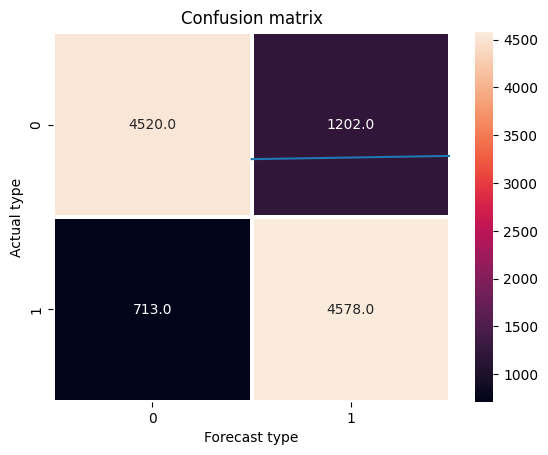

In [166]:
data_totaltry = df_.copy(deep = True)
new_text = data_totaltry['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
  
new_text = []
for txt in data_totaltry.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)

vectorizer_text = CountVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()

data_totaltry.drop(["title","text","subject","tags",'mistake','date','news','word_count','char_count'],axis=1,inplace=True)

# Creating Y
y = data_totaltry.output
# Creating X
x = np.concatenate((np.array(data_totaltry.drop("output",axis=1)),text_matrix),axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.25,random_state=1)

class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN,self).__init__() # Inhertiting
        
        self.linear1 = nn.Linear(X_train.shape[1],20) #  OUT 2000
        self.relu1 = nn.ReLU() # Actfunc 1
        
        self.linear2 = nn.Linear(20,5) # IN 2000 OUT 500
        self.relu2 = nn.ReLU()
        
        self.linear5 = nn.Linear(5,2) # IN 20 OUT 2 | OUTPUT 
        
    
    def forward(self,x):
        
        out = self.linear1(x) # Input Layer 
        out = self.relu1(out)
        
        out = self.linear2(out) # Hidden Layer 1 
        out = self.relu2(out)

        
        out = self.linear5(out) # Output Layer
        
        return out
    

model = ANN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
error = nn.CrossEntropyLoss()

# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

EPOCHS = 100
train_losses = []
for epoch in range(EPOCHS):
    
    # Clearing gradients
    optimizer.zero_grad()
    
    # Forward Propagation
    outs = model(X_train)
    
    # Computing Loss
    train_loss = 0
    loss = error(outs,Y_train)
    train_loss += loss.item()
    # Backward propagation
    loss.backward()
    # Updating parameters
    optimizer.step()
    
    # Printing loss
    train_losses.append(train_loss)


rg = list(range(1,101))
plt.plot(rg,train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Prediction
y_head = model(X_test)
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(Y_test, y_pred)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)
print('测试数据指标:\n',classification_report(Y_test, y_pred,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

ANN  N+CL+NE

      0     1
0  4576  1146
1   648  4643
测试数据指标:
               precision    recall  f1-score   support

         0.0     0.8760    0.7997    0.8361      5722
         1.0     0.8020    0.8775    0.8381      5291

    accuracy                         0.8371     11013
   macro avg     0.8390    0.8386    0.8371     11013
weighted avg     0.8404    0.8371    0.8371     11013



Text(0.5, 23.52222222222222, 'Forecast type')

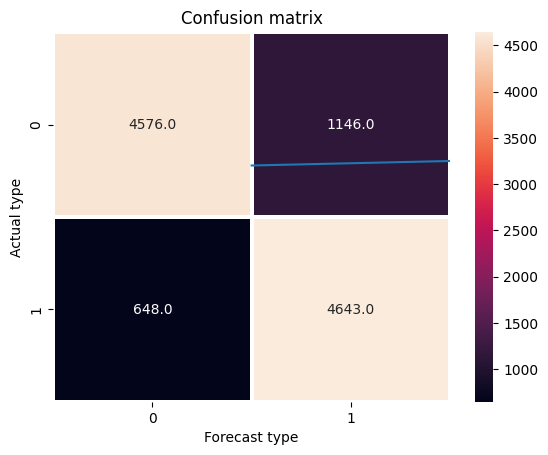

In [165]:
data_totaltry = df_.copy(deep = True)
new_text = data_totaltry['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
  
new_text = []
for txt in data_totaltry.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)

vectorizer_text = CountVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()

data_totaltry.drop(["title","text","subject","tags",'mistake','date','news'],axis=1,inplace=True)

# Creating Y
y = data_totaltry.output
# Creating X
x = np.concatenate((np.array(data_totaltry.drop("output",axis=1)),text_matrix),axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.25,random_state=1)

class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN,self).__init__() # Inhertiting
        
        self.linear1 = nn.Linear(X_train.shape[1],20) #  OUT 2000
        self.relu1 = nn.ReLU() # Actfunc 1
        
        self.linear2 = nn.Linear(20,5) # IN 2000 OUT 500
        self.relu2 = nn.ReLU()
        
        self.linear5 = nn.Linear(5,2) # IN 20 OUT 2 | OUTPUT 
        
    
    def forward(self,x):
        
        out = self.linear1(x) # Input Layer 
        out = self.relu1(out)
        
        out = self.linear2(out) # Hidden Layer 1 
        out = self.relu2(out)

        
        out = self.linear5(out) # Output Layer
        
        return out
    

model = ANN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
error = nn.CrossEntropyLoss()

# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

EPOCHS = 100
train_losses = []
for epoch in range(EPOCHS):
    
    # Clearing gradients
    optimizer.zero_grad()
    
    # Forward Propagation
    outs = model(X_train)
    
    # Computing Loss
    train_loss = 0
    loss = error(outs,Y_train)
    train_loss += loss.item()
    # Backward propagation
    loss.backward()
    # Updating parameters
    optimizer.step()
    
    # Printing loss
    train_losses.append(train_loss)


rg = list(range(1,101))
plt.plot(rg,train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Prediction
y_head = model(X_test)
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(Y_test, y_pred)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)
print('测试数据指标:\n',classification_report(Y_test, y_pred,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

ANN N+M+CL+NE

      0     1
0  4731   991
1   693  4598
测试数据指标:
               precision    recall  f1-score   support

         0.0     0.8722    0.8268    0.8489      5722
         1.0     0.8227    0.8690    0.8452      5291

    accuracy                         0.8471     11013
   macro avg     0.8475    0.8479    0.8471     11013
weighted avg     0.8484    0.8471    0.8471     11013



Text(0.5, 23.52222222222222, 'Forecast type')

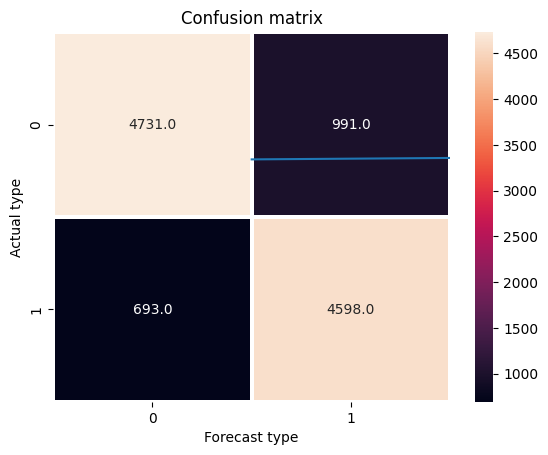

In [170]:
data_totaltry = df_.copy(deep = True)
new_text = data_totaltry['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
  
new_text = []
for txt in data_totaltry.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)

vectorizer_text = CountVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()
data_totaltry.drop(["title","text","subject","tags",'date','news'],axis=1,inplace=True)

# Creating Y
y = data_totaltry.output
# Creating X
x = np.concatenate((np.array(data_totaltry.drop(["output"],axis = 1)),text_matrix),axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.25,random_state=1)


class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN,self).__init__() # Inhertiting
        
        self.linear1 = nn.Linear(X_train.shape[1],20) #  OUT 2000
        self.relu1 = nn.ReLU() # Actfunc 1
        
        self.linear2 = nn.Linear(20,5) # IN 2000 OUT 500
        self.relu2 = nn.ReLU()
        
        self.linear5 = nn.Linear(5,2) # IN 20 OUT 2 | OUTPUT 
        
    
    def forward(self,x):
        
        out = self.linear1(x) # Input Layer 
        out = self.relu1(out)
        
        out = self.linear2(out) # Hidden Layer 1 
        out = self.relu2(out)

        
        out = self.linear5(out) # Output Layer
        
        return out
    

model = ANN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
error = nn.CrossEntropyLoss()

# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

EPOCHS = 100
train_losses = []
for epoch in range(EPOCHS):
    
    # Clearing gradients
    optimizer.zero_grad()
    
    # Forward Propagation
    outs = model(X_train)
    
    # Computing Loss
    train_loss = 0
    loss = error(outs,Y_train)
    train_loss += loss.item()
    # Backward propagation
    loss.backward()
    # Updating parameters
    optimizer.step()
    
    # Printing loss
    train_losses.append(train_loss)


rg = list(range(1,101))
plt.plot(rg,train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Prediction
y_head = model(X_test)
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(Y_test, y_pred)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)
print('测试数据指标:\n',classification_report(Y_test, y_pred,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for Mistakes

每一次的得分 [0.51150121 0.52845036 0.52845036 0.51785714 0.50847458 0.50635593
 0.51059322 0.5248184  0.50242131 0.52921586]
平均得分 0.5168138382525534
      0     1
0  3586  2136
1  3188  2103
测试数据指标:
               precision    recall  f1-score   support

           0     0.5294    0.6267    0.5739      5722
           1     0.4961    0.3975    0.4413      5291

    accuracy                         0.5166     11013
   macro avg     0.5127    0.5121    0.5076     11013
weighted avg     0.5134    0.5166    0.5102     11013



Text(0.5, 23.52222222222222, 'Forecast type')

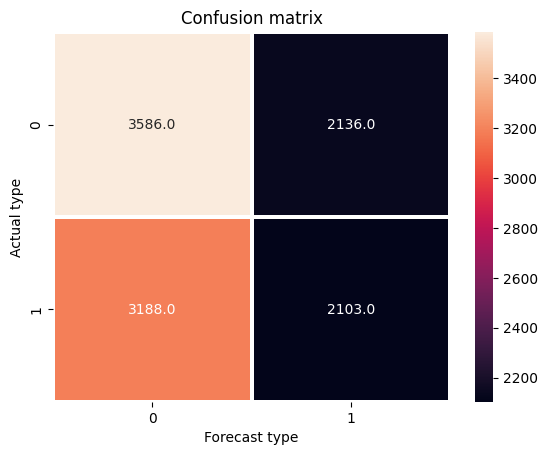

In [201]:
M = data_total3.copy(deep = True)
M['mistake'] = data_total3['mistake']


col = ['mistake']
x = M[col]
y = M['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for CL

每一次的得分 [0.51150121 0.52845036 0.52845036 0.51785714 0.50847458 0.50635593
 0.51059322 0.5248184  0.50242131 0.52921586]
平均得分 0.5168138382525534
      0     1
0  3586  2136
1  3188  2103
测试数据指标:
               precision    recall  f1-score   support

           0     0.5294    0.6267    0.5739      5722
           1     0.4961    0.3975    0.4413      5291

    accuracy                         0.5166     11013
   macro avg     0.5127    0.5121    0.5076     11013
weighted avg     0.5134    0.5166    0.5102     11013



Text(0.5, 23.52222222222222, 'Forecast type')

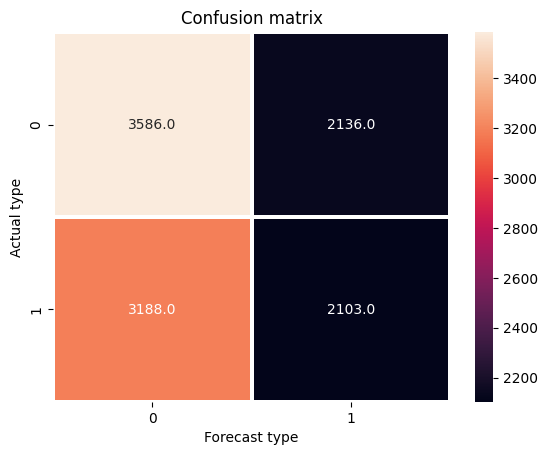

In [284]:
A = df_.copy(deep = True)

col = ['mistake']
x = A[col]
y = A['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

LR Baseline

每一次的得分 [0.781477   0.77754237 0.7972155  0.76997579 0.77905569 0.78813559
 0.79025424 0.78450363 0.79085956 0.791099  ]
平均得分 0.7850118371368313
      0     1
0  4261  1461
1   995  4296
测试数据指标:
               precision    recall  f1-score   support

           0     0.8107    0.7447    0.7763      5722
           1     0.7462    0.8119    0.7777      5291

    accuracy                         0.7770     11013
   macro avg     0.7785    0.7783    0.7770     11013
weighted avg     0.7797    0.7770    0.7770     11013



Text(0.5, 23.52222222222222, 'Forecast type')

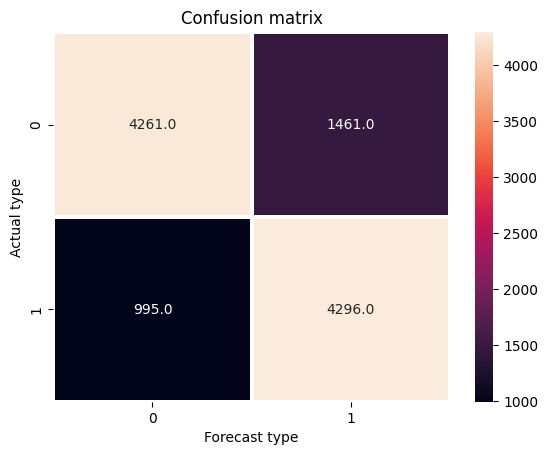

In [125]:
B= df_.copy(deep = True)

new_text = B['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
    

vectorizer_text = TfidfVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


x = text_matrix

y = B['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression. N + CL

每一次的得分 [0.77996368 0.77330508 0.79661017 0.77602906 0.77935835 0.78783293
 0.79025424 0.78117433 0.7938862  0.791099  ]
平均得分 0.78495130444918
      0     1
0  4283  1439
1   999  4292
测试数据指标:
               precision    recall  f1-score   support

           0     0.8109    0.7485    0.7784      5722
           1     0.7489    0.8112    0.7788      5291

    accuracy                         0.7786     11013
   macro avg     0.7799    0.7799    0.7786     11013
weighted avg     0.7811    0.7786    0.7786     11013



Text(0.5, 23.52222222222222, 'Forecast type')

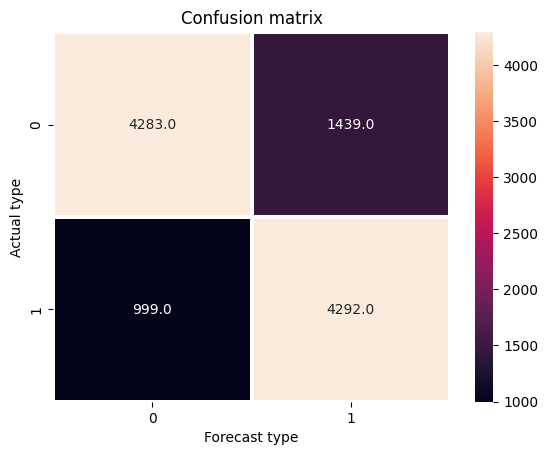

In [354]:
B= df_.copy(deep = True)

new_text = B['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
    

vectorizer_text = TfidfVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


col = ['word_count','char_count']
x = B[col]
x = np.concatenate((np.array(x),text_matrix),axis=1)

y = B['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for NER

每一次的得分 [0.76361985 0.76089588 0.77391041 0.74122276 0.75998789 0.75696126
 0.76331719 0.77542373 0.78329298 0.77172268]
平均得分 0.7650354637613909
      0     1
0  4489  1233
1  1383  3908
测试数据指标:
               precision    recall  f1-score   support

           0     0.7645    0.7845    0.7744      5722
           1     0.7602    0.7386    0.7492      5291

    accuracy                         0.7625     11013
   macro avg     0.7623    0.7616    0.7618     11013
weighted avg     0.7624    0.7625    0.7623     11013



Text(0.5, 23.52222222222222, 'Forecast type')

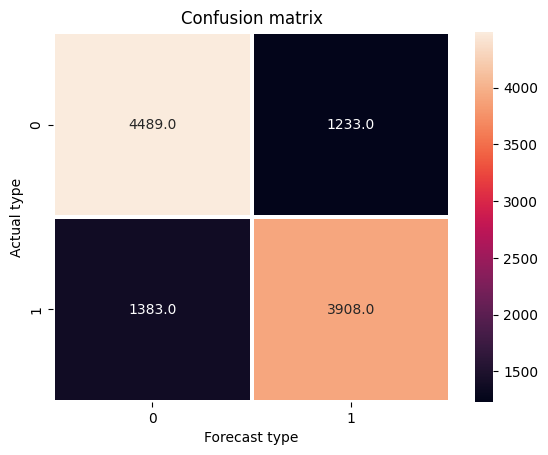

In [278]:
C = df_.copy(deep = True)
C = C.drop(["title","text","subject","tags","date",'word_count','char_count','mistake'],axis=1)


x = C.drop(['output'],axis=1)
y = C['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

N+NE

每一次的得分 [0.81355932 0.81628329 0.82960048 0.8062954  0.81779661 0.81719128
 0.82112591 0.82112591 0.82233656 0.82894338]
平均得分 0.8194258154777483
      0     1
0  4547  1175
1   856  4435
测试数据指标:
               precision    recall  f1-score   support

           0     0.8416    0.7947    0.8174      5722
           1     0.7906    0.8382    0.8137      5291

    accuracy                         0.8156     11013
   macro avg     0.8161    0.8164    0.8156     11013
weighted avg     0.8171    0.8156    0.8156     11013



Text(0.5, 23.52222222222222, 'Forecast type')

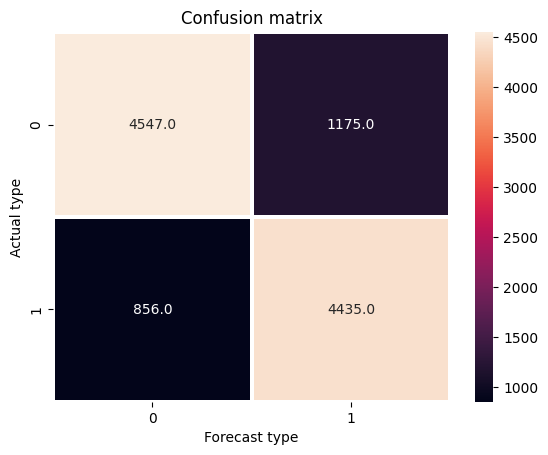

In [132]:
B= df_.copy(deep = True)

new_text = B['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
    

vectorizer_text = TfidfVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


B = B.drop(["title","text","subject","tags","date",'news','mistake','word_count','char_count'],axis=1)
y = B['output']
B = B.drop(['output'],axis=1)
x = np.concatenate((np.array(B),text_matrix),axis=1)


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for NER, CL and mistakes 

每一次的得分 [0.80508475 0.81598063 0.82960048 0.79358354 0.81265133 0.81053269
 0.80508475 0.82021792 0.812046   0.81108084]
平均得分 0.8115862917928451
      0     1
0  4682  1040
1   977  4314
测试数据指标:
               precision    recall  f1-score   support

           0     0.8274    0.8182    0.8228      5722
           1     0.8058    0.8153    0.8105      5291

    accuracy                         0.8169     11013
   macro avg     0.8166    0.8168    0.8166     11013
weighted avg     0.8170    0.8169    0.8169     11013



Text(0.5, 23.52222222222222, 'Forecast type')

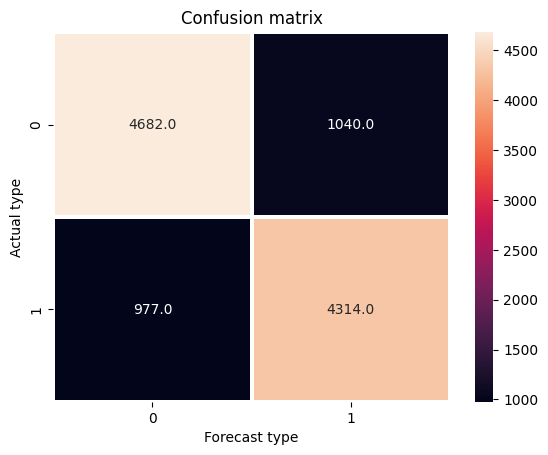

In [205]:
D = df_.copy(deep = True)

D = D.drop(["title","text","subject","tags","date",],axis=1)

x = D.drop(['output'],axis=1)
y = D['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

N+CL+NE

每一次的得分 [0.83958838 0.83504843 0.85078692 0.82082324 0.83232446 0.84231235
 0.84291768 0.83686441 0.8468523  0.85225553]
平均得分 0.8399773685086345
      0     1
0  4690  1032
1   756  4535
测试数据指标:
               precision    recall  f1-score   support

           0     0.8612    0.8196    0.8399      5722
           1     0.8146    0.8571    0.8353      5291

    accuracy                         0.8376     11013
   macro avg     0.8379    0.8384    0.8376     11013
weighted avg     0.8388    0.8376    0.8377     11013



Text(0.5, 23.52222222222222, 'Forecast type')

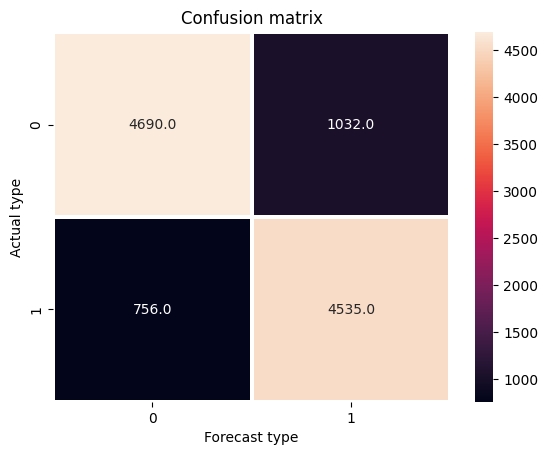

In [131]:
B= df_.copy(deep = True)

new_text = B['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
    

vectorizer_text = TfidfVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


B = B.drop(["title","text","subject","tags","date",'news','mistake'],axis=1)
y = B['output']
B = B.drop(['output'],axis=1)
x = np.concatenate((np.array(B),text_matrix),axis=1)


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for NER, CL and mistakes and N

每一次的得分 [0.83898305 0.83535109 0.85169492 0.82173123 0.83323245 0.84443099
 0.84291768 0.83928571 0.84776029 0.85225553]
平均得分 0.8407642934481017
      0     1
0  4682  1040
1   747  4544
测试数据指标:
               precision    recall  f1-score   support

           0     0.8624    0.8182    0.8397      5722
           1     0.8138    0.8588    0.8357      5291

    accuracy                         0.8377     11013
   macro avg     0.8381    0.8385    0.8377     11013
weighted avg     0.8390    0.8377    0.8378     11013



Text(0.5, 23.52222222222222, 'Forecast type')

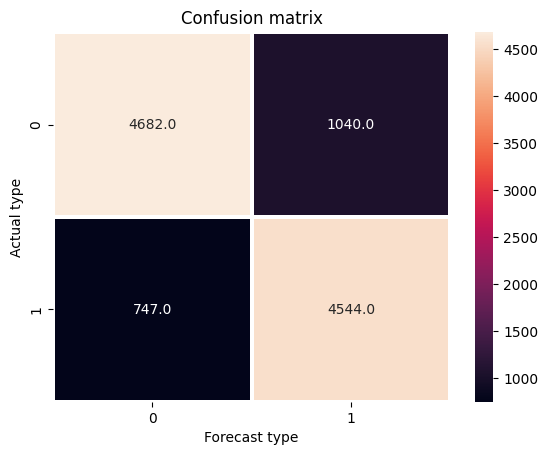

In [130]:
B= df_.copy(deep = True)

new_text = B['text']
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
    

vectorizer_text = TfidfVectorizer(stop_words="english",max_features=4)

text_matrix = vectorizer_text.fit_transform(new_text).toarray()


B = B.drop(["title","text","subject","tags","date",'news'],axis=1)
y = B['output']
B = B.drop(['output'],axis=1)
x = np.concatenate((np.array(B),text_matrix),axis=1)


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for mistakes , CL 

每一次的得分 [0.55115012 0.55236077 0.562046   0.55175545 0.55569007 0.5596247
 0.54751816 0.55932203 0.54570218 0.55888586]
平均得分 0.5544055352863602
      0     1
0  3057  2665
1  2311  2980
测试数据指标:
               precision    recall  f1-score   support

           0     0.5695    0.5343    0.5513      5722
           1     0.5279    0.5632    0.5450      5291

    accuracy                         0.5482     11013
   macro avg     0.5487    0.5487    0.5481     11013
weighted avg     0.5495    0.5482    0.5483     11013



Text(0.5, 23.52222222222222, 'Forecast type')

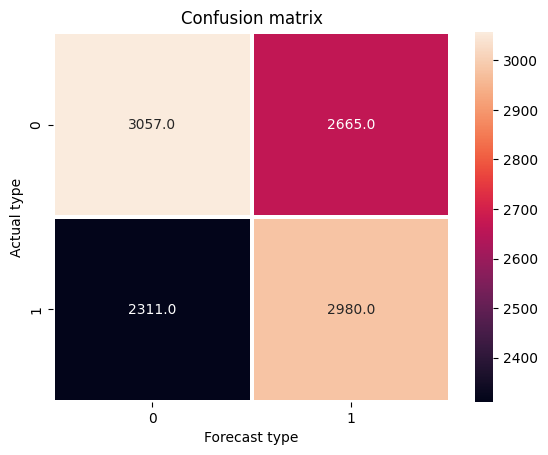

In [269]:
E= df_.copy(deep = True)

col = ['mistake','word_count','char_count']
x = E[col]
y = E['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for mistakes, NER

每一次的得分 [0.76029056 0.76210654 0.76937046 0.74182809 0.7624092  0.75968523
 0.76331719 0.77512107 0.77875303 0.76778686]
平均得分 0.7640668216362115
      0     1
0  4488  1234
1  1387  3904
测试数据指标:
               precision    recall  f1-score   support

           0     0.7639    0.7843    0.7740      5722
           1     0.7598    0.7379    0.7487      5291

    accuracy                         0.7620     11013
   macro avg     0.7619    0.7611    0.7613     11013
weighted avg     0.7620    0.7620    0.7618     11013



Text(0.5, 23.52222222222222, 'Forecast type')

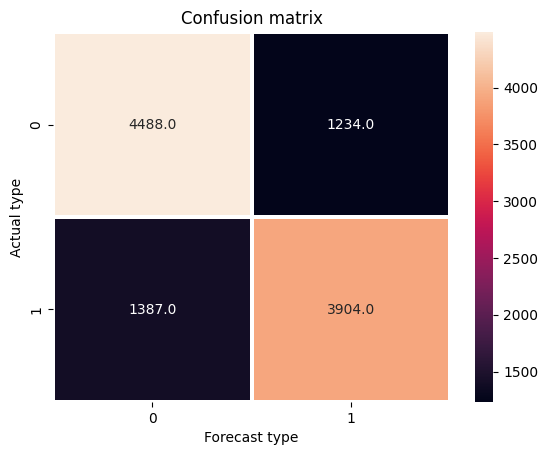

In [279]:
MN = df_.copy(deep = True)
MN = MN.drop(["title","text","subject","tags","date",'word_count','char_count',],axis=1)


x = MN.drop(['output'],axis=1)
y = MN['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

Logistic Regression for CL, NER

每一次的得分 [0.80841404 0.81507264 0.83020581 0.79993947 0.81688862 0.8096247
 0.80357143 0.81779661 0.81688862 0.81380563]
平均得分 0.8132207568290328
      0     1
0  4670  1052
1   964  4327
测试数据指标:
               precision    recall  f1-score   support

           0     0.8289    0.8161    0.8225      5722
           1     0.8044    0.8178    0.8111      5291

    accuracy                         0.8169     11013
   macro avg     0.8167    0.8170    0.8168     11013
weighted avg     0.8171    0.8169    0.8170     11013



Text(0.5, 23.52222222222222, 'Forecast type')

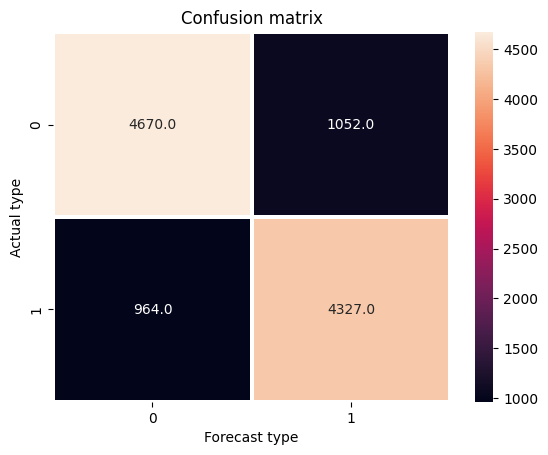

In [280]:
CN = df_.copy(deep = True)
CN = CN.drop(["title","text","subject","tags","date",'mistake'],axis=1)


x = CN.drop(['output'],axis=1)
y = CN['output']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=1)

lr = LogisticRegression(multi_class='auto',solver='lbfgs',class_weight='balanced',max_iter=1000)

lr.fit(x_train,y_train)

y_predict = lr.predict(x_test)

#k-fold交叉验证得分
scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')
print('每一次的得分',scores)
print('平均得分', scores.mean())

labelEncoder = LabelEncoder()
labelEncoder.fit(y)##对变量y进行硬编码，将标签变为数字
cm = confusion_matrix(y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=labelEncoder.classes_, index=labelEncoder.classes_)
print(cm_pd)

print('测试数据指标:\n',classification_report(y_test,y_predict,digits=4))
sns.heatmap(cm,annot=True,fmt="0.1f",linewidths=1.5)
plt.title('Confusion matrix')
plt.ylabel('Actual type') #实际类型
plt.xlabel('Forecast type') #预测类型

(0.0, 0.06)

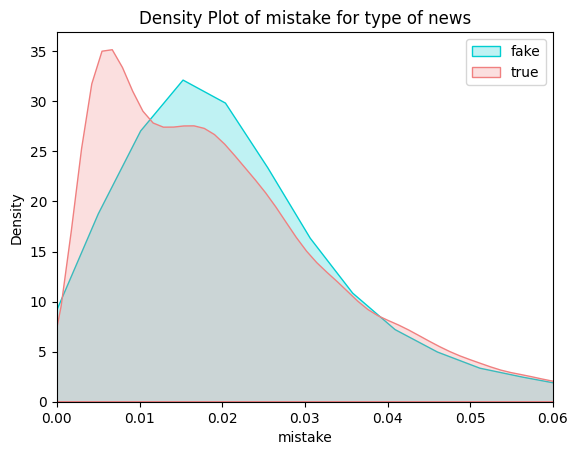